# Estimate rates

In [66]:
import numpy as np
import matplotlib.pylab as plt

from scipy.integrate import solve_ivp

import pickle
import sys

In [ ]:
sys.path.append("../src/")
from Hypergraphs import CompleteHypergraph
from simulate_gillespie import *
from solve_kolmogorov import *
from estimate_total_rates import *

In [99]:
# --- Setup ---
g_type = "complete"

# TODO: increase these values
N = 100
g = CompleteHypergraph(N)

I0 = 1

time_max = 20

betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]
betas_unscaled = betas_unscaled_selected[2] # 0.75N regime

beta1 = betas_unscaled[0] / N       # pairwise infection rate
beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\t H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t beta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu}")

Setup: 

	 H = Complete Hypergraph, N = 100, I0 = 1, time_max = 20,
	 beta1 * N = 5.667, beta2 * N^2 = 13.414, mu = 1


## Run Gillespie

In [61]:
run_gillespie_simulations = False

I0_gillespie = 1

nsims = 50

initial_infections = list(range(I0_gillespie))
initial_infections

[0]

In [62]:
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(
            g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed('../results/sim_results.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load('../results/sim_results.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

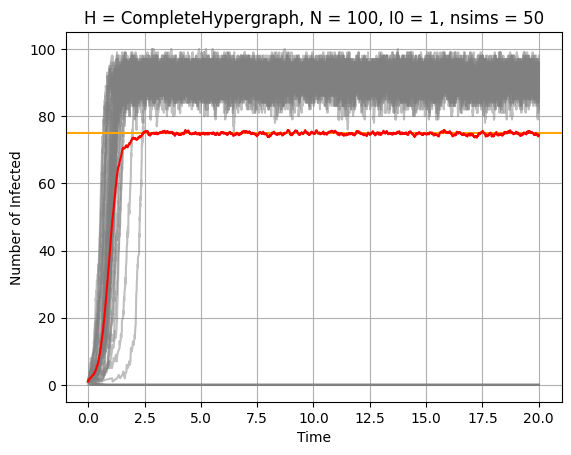

In [ ]:
# plot X_t curves in gray and average curve in red
fig = plt.figure()
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=75, color='orange', linestyle='-')

plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, I0 = {I0_gillespie}, nsims = {nsims}")

plt.savefig("../figures/estimation/complete/theoretical-rates.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Solve KEs and compare

In [53]:
M = N + 1
all_states = list_all_states(g)
M, len(all_states)

(101, 101)

In [54]:
# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)

p0 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


In [55]:
ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

expected_values = calculate_expected_values(sol)

In [56]:
times.shape, sol.t.shape

((2002,), (101,))

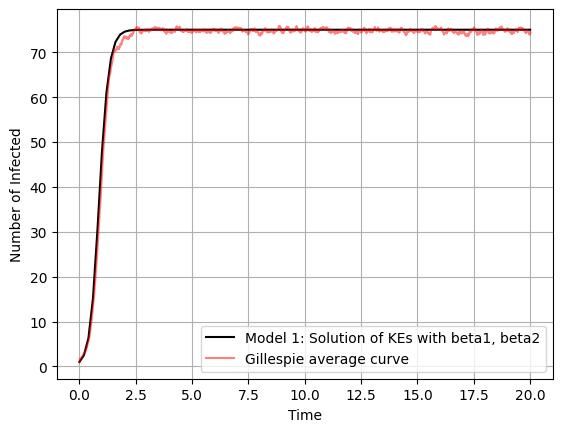

In [59]:
plt.figure()
plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.show()

## Calculate the estimates

In [68]:
estimates = calculate_estimates(X_sims, N)

In [72]:
# theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))

a_k = beta1 * k_values * (N - k_values)
b_k = beta2 * k_choose_2 * (N - k_values)
c_k = mu * k_values

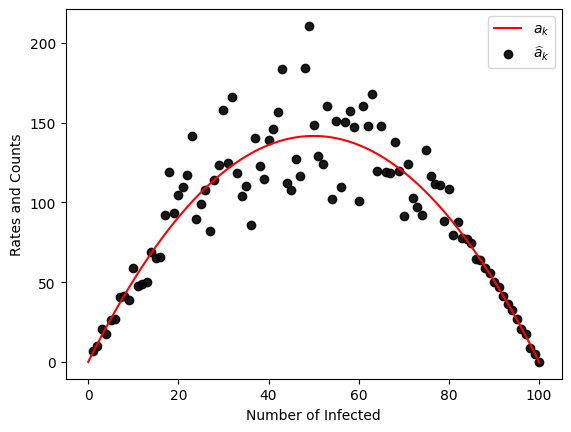

In [89]:
fig = plt.figure()
ax = plt.subplot()

# theoretical rates
ax.plot(k_values, a_k, label=r'$a_k$', color="red")

# estimates 
ax.scatter(estimates["k_values_hat"], estimates["a_k_hat"],
           label=r'$\widehat{a}_k$', color="black", alpha=0.9)

# ax.scatter(estimates["k_values_hat"], beta1 * estimates["a_k_tilde"],
#            label=r'$\widetilde{a}_k$', color="darkgreen", alpha=0.5, s=100, marker='^')

plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.show()

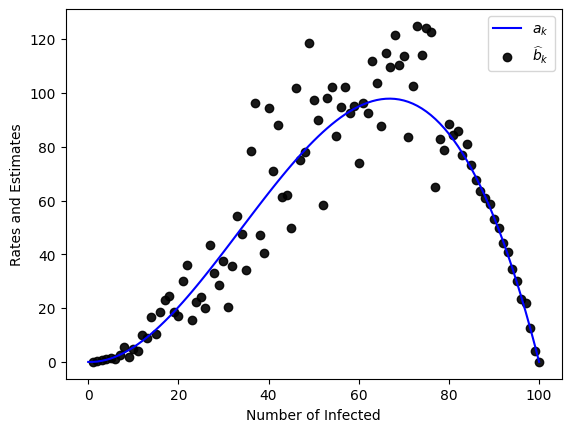

In [ ]:
fig = plt.figure()
ax = plt.subplot()

# theoretical rates
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")

# estimates 
ax.scatter(estimates["k_values_hat"], estimates["b_k_hat"],
           label=r'$\widehat{b}_k$', color="black", alpha=0.9)

# ax.scatter(estimates["k_values_hat"], beta2 * estimates["b_k_tilde"],
#            label=r'$\beta_2 \cdot \widetilde{b}_k$', color="darkgreen", alpha=0.5, s=100, marker='^')

plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.show()

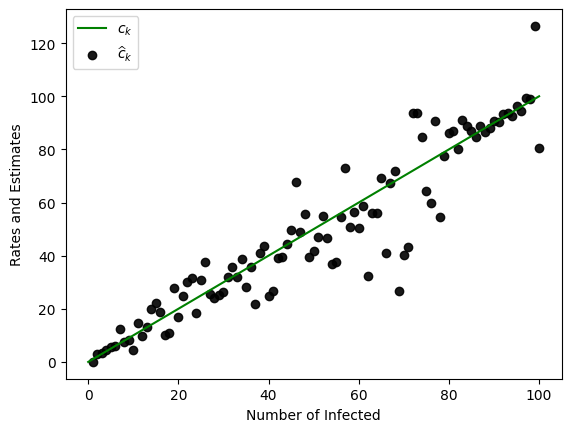

In [91]:
fig = plt.figure()
ax = plt.subplot()

# theoretical rates
ax.plot(k_values, c_k, label=r'$c_k$', color="green")

# estimates 
ax.scatter(estimates["k_values_hat"], estimates["c_k_hat"],
           label=r'$\widehat{c}_k$', color="black", alpha=0.9)

# ax.scatter(estimates["k_values_hat"], mu * np.array(estimates["k_values_hat"]),
#            label=r'$\mu \cdot k$', color="darkgreen", alpha=0.5, s=100, marker='^')

plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.show()

## Solve KEs using the estimates 

In [96]:
def list_all_ODEs_using_estimates(g, ak_hats, bk_hats, mu):
    r"""Returns the list of forward Kolmogorov equations dp_{k}(t)/dt = ...
        using given estimates a_k, b_k
    """
    N = g.number_of_nodes()
    all_states = list_all_states(g)
    M = len(all_states)
    
    def ode_system_complete(t, p):
      r"""Given p = p(t) a vector of length M, returns dp / dt where p[i] is:

        * In case of complete hypergraph p[i] is simply p[k]:
          p[i] = p[k] = p_{k}(t) for state_k, such that: all_states[i] = state_k = k
      """
      dpdt = np.zeros(M, dtype=float)
      for k in range(M):
          if k == 0:
              dpdt[0] = mu * p[1]
          elif k == N:
              # infections from state N - 1, infecting the remaining v
              infection_rate = ak_hats[N - 1] + bk_hats[N - 1]
              dpdt[N] += infection_rate * p[N - 1] # NOTE: bug fixed N - 1 instead of N!

              # or no event, that is none of N infected nodes recovers
              dpdt[N] -= (N * mu) * p[N]
          else: 
              # I. infection from state k - 1 to k
              infection_rate = ak_hats[k - 1] + bk_hats[k - 1]
              dpdt[k] += infection_rate * p[k - 1]

              # II. recovery from state k + 1 to k
              dpdt[k] += mu * (k + 1) * p[k + 1]

              # III. no event
              outflow_rate = ak_hats[k] + bk_hats[k] + mu * k
              dpdt[k] -= outflow_rate * p[k]
      return dpdt
    return ode_system_complete

In [97]:
ode_system_complete = list_all_ODEs_using_estimates(
    g, estimates["a_k_hat"], estimates["b_k_hat"], mu)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

expected_values_2 = calculate_expected_values(sol)

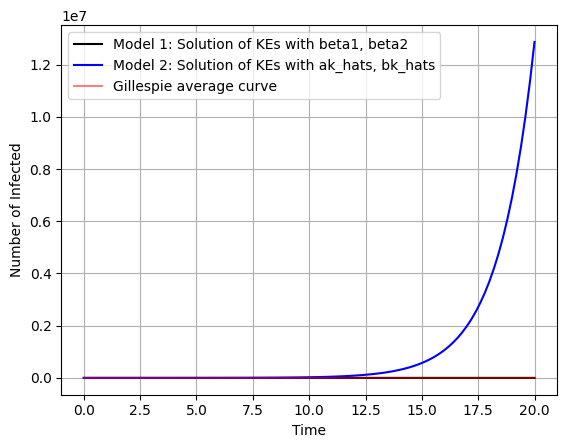

In [98]:
plt.figure()
plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")
plt.plot(sol.t, expected_values_2, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.show()